# Import all libraries

In [ ]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed , Layer,AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Read the dataset

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files 
!gdown --id 11VB2SO60aqc6Rnnxn4bDHp0tToMIh3r0
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets list -s amazon-fine-food-reviews
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=11VB2SO60aqc6Rnnxn4bDHp0tToMIh3r0
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 103kB/s]
401 - Unauthorized
401 - Unauthorized
unzip:  cannot find or open amazon-fine-food-reviews, amazon-fine-food-reviews.zip or amazon-fine-food-reviews.ZIP.


In [ ]:
df = pd.read_csv('Reviews.csv')
df=df[:20000]
df = df[ ['Summary', 'Text']]
df.replace("", float("NaN"), inplace=True)

#dropping duplicates
df.drop_duplicates(subset=['Text'],inplace=True)
#dropping na
df.dropna(axis=0,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19308 entries, 0 to 19978
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  19308 non-null  object
 1   Text     19308 non-null  object
dtypes: object(2)
memory usage: 452.5+ KB


# Preprocessing

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text, remove_stopwords = True):
    cleanedString = text.lower() #Convert everything to lowercase
    cleanedString = re.sub(r'\([^)]*\)', '', cleanedString) 
    cleanedString = re.sub('"','', cleanedString) #Replace double quotes   
    cleanedString = re.sub(r"'s\b","",cleanedString) #Remove (-)
    cleanedString = re.sub("[^a-zA-Z]", " ", cleanedString) #Eliminate punctuations and special characters
    if remove_stopwords:
        tokens = [w for w in cleanedString.split() if not w in stop_words] #Remove stopwords
    else:
        tokens=cleanedString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:   #Remove short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
#Calling the function on Source
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t, remove_stopwords = False))
    
print(cleaned_text[:5])

['have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like stew than processed meat and it smells better my labrador is finicky and she appreciates this product better than most', 'product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo', 'this is confection that has been around few centuries it is light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is tiny mouthful of heaven not too chewy and very flavorful highly recommend this yummy treat if you are familiar with the story of lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sisters to the witch', 'if you are looking for the secret ingredient in robitussin believe have found 

In [ ]:
#Calling the function on Target
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t, remove_stopwords = False))

print(cleaned_summary[:5])

['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [ ]:
cleaned_data=pd.DataFrame()
cleaned_data['cleaned_text']=cleaned_text
cleaned_data['cleaned_summary']=cleaned_summary

# Drop Empty Rows

In [ ]:
cleaned_data.replace('', np.nan, inplace=True)
cleaned_data.dropna(axis=0,inplace=True)
print(cleaned_data.shape)

(19289, 2)


# EDA on Text Sequences
Here, we will analyze the length of the source and the target to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

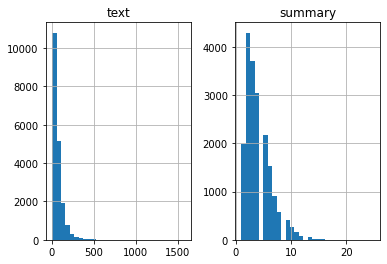

In [ ]:
source_word_count = []
target_word_count = []

# Appending sequence lengths to the lists
for i in cleaned_data['cleaned_text']:
      source_word_count.append(len(i.split()))

for i in cleaned_data['cleaned_summary']:
      target_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':source_word_count, 'summary':target_word_count})

length_df.hist(bins = 30)
plt.show()

Let us understand what percentage of source and target sequences fall below 100 and 20 respectively. This will help us understand where to cap the sequence length.

In [ ]:
cnt=0
for i in cleaned_data['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(cleaned_data['cleaned_text']))

0.7924723935922028


In [ ]:
cnt=0
for i in cleaned_data['cleaned_summary']:
    if(len(i.split())<=20):
        cnt=cnt+1
print(cnt/len(cleaned_data['cleaned_summary']))

0.9996370988646379


We can fix the maximum length of the target to 20 since that seems to capture majority of the words in the sequence.
For the source sequence length, we can fix that to 100 as it captures 88% of the total sequences in the dataset.

In [ ]:
max_text_len=100
max_summary_len=20

Let us select the source and target sentences whose length is less than or equal to **max_text_len** and **max_summary_len**.

In [ ]:
cleaned_text = np.array(cleaned_data['cleaned_text'])
cleaned_summary = np.array(cleaned_data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df_cleaned_data_short=pd.DataFrame({'source':short_text,'target':short_summary})

Now, we add the **startsymbol** and **endsymbol** special tokens at the beginning and end of the target sentence. Note, this is only for the target sequence, not for the source sequence.

In [ ]:
df_cleaned_data_short['target'] = df_cleaned_data_short['target'].apply(lambda x : 'startsymbol '+ x + ' endsymbol')

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_cleaned_data_short['source'].values, df_cleaned_data_short['target'].values,
                                               test_size=0.1, random_state=123, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(13753,) (13753,)
(1529,) (1529,)


# Source Text Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#Tokenize source words in training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

#Convert text sequences into integer sequences
x_train_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#Padding with zero upto maximum length
x_train = pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#Size of vocabulary (+1 for padding token)
x_vocab = len(x_tokenizer.word_index) + 1
print(x_vocab)

16553


# Target Text Tokenizer

In [ ]:
#Tokenize target words in training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

#Convert text sequences into integer sequences
y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

#Padding with zero upto maximum length
y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#Size of vocabulary (+1 for padding token)
y_vocab = len(y_tokenizer.word_index) +1
print(y_vocab)

5147


# Model Build
Here, we are building a 3 stacked LSTM for the encoder:

## Encoder Model
- Embedding Layer
- 3 LSTM



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           827650    
_________________________________________________________________
lstm (LSTM)                  [(None, 100, 100), (None, 60400     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 100, 100), (None, 80400     
_________________________________________________________________
lstm_2 (LSTM)                [(None, 100, 100), (None, 80400     
Total params: 1,048,850
Trainable params: 1,048,850
Non-trainable params: 0
_________________________________________________________________


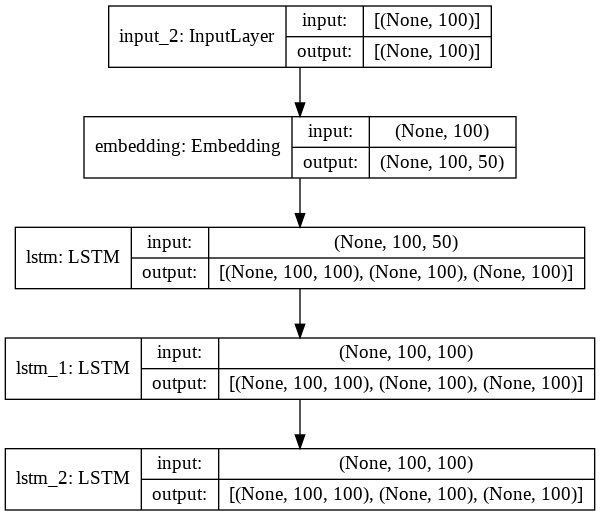

In [ ]:
import keras
from keras import backend as K 
K.clear_session()

time_dim = max_text_len
embedding_dim=50
#################################################################### Encoder ####################################################################


encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
encoder_embedding =  Embedding(x_vocab, embedding_dim,trainable=True)(encoder_inputs)

######## Encoder lstm layers ########
encoder_lstm_layer_1 = LSTM(time_dim,return_sequences=True,return_state=True,dropout=0.25)
encoder_output1, h1_state, c1_state = encoder_lstm_layer_1(encoder_embedding)

encoder_lstm_layer_2 = LSTM(time_dim,return_sequences=True,return_state=True,dropout=0.25)
encoder_output2, h2_state, c2_state = encoder_lstm_layer_2(encoder_output1)

encoder_lstm_layer_3=LSTM(time_dim, return_state=True, return_sequences=True,dropout=0.25)
encoder_outputs, h_final, c_final= encoder_lstm_layer_3(encoder_output2)


encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, h_final, c_final])
encoder_model.summary()
keras.utils.all_utils.plot_model(encoder_model, "encoder.png", show_shapes=True)

## Attention layer
- 2 Dense layers : one for the encoder outputs, other for the Decoder outputs 
- Additive attention



In [ ]:
import tensorflow as tf

class BahdanauAttention(Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = Dense(units, use_bias=False)
    self.W2 = Dense(units, use_bias=False)

    self.attention = AdditiveAttention()

  def call(self, query, value, mask=None):

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    return context_vector, attention_weights

## Decoder Model
- Embedding Layer
- 1 LSTM



In [ ]:

#################################################################### Decoder ####################################################################
decoder_inputs = Input(shape=(None,))

######## embedding layer ########
dec_emb_layer = Embedding(y_vocab, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
######## Decoder lstm layer ########
decoder_lstm = LSTM(time_dim, return_sequences=True, return_state=True,dropout=0.25)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb ,initial_state=[h_final, c_final])




######## Attention layer ########
attn_layer = BahdanauAttention(time_dim)
attn_out, attn_states = attn_layer( decoder_outputs,encoder_outputs)

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


######## Decoder Output layer ########
decoder_dense =  TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)


## Encoder-Decoder seq2seq Model
- Encoder
- Decoder



In [ ]:
#################################################################### Model ####################################################################
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      827650      input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 100), ( 60400       embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

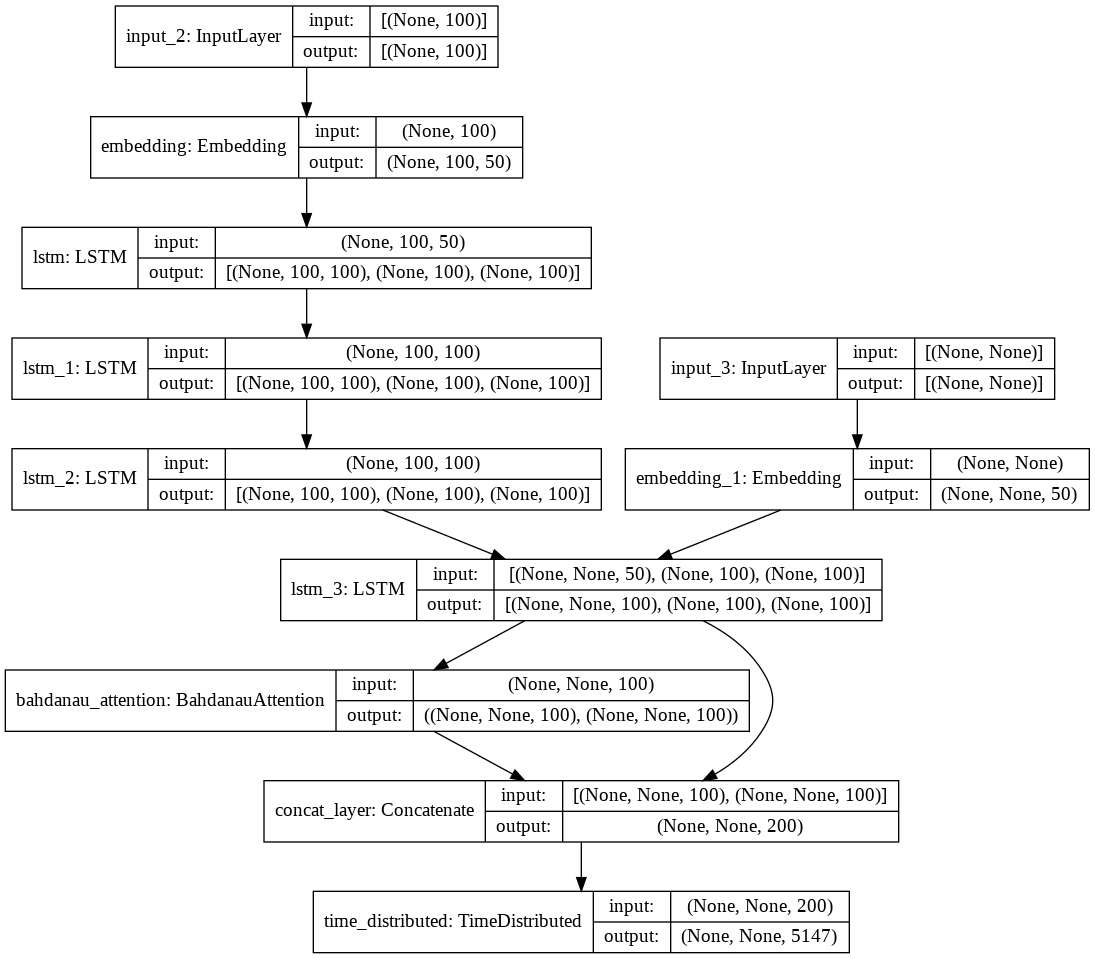

In [ ]:
import keras
keras.utils.all_utils.plot_model(model, "model.png", show_shapes=True)

# Model Build
Here, we are building a 3 stacked LSTM for the encoder:

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoint_path = "/content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Mounted at /content/drive


In [ ]:
epochs = 40
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
                  epochs=epochs, callbacks=[es,cp_callback], batch_size=20)

Epoch 1/40
688/688 [==============================] - 34s 33ms/step - loss: 1.5793 - val_loss: 1.1907

Epoch 00001: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0001.ckpt
Epoch 2/40
688/688 [==============================] - 21s 31ms/step - loss: 1.2855 - val_loss: 1.1636

Epoch 00002: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0002.ckpt
Epoch 3/40
688/688 [==============================] - 21s 31ms/step - loss: 1.2465 - val_loss: 1.1412

Epoch 00003: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0003.ckpt
Epoch 4/40
688/688 [==============================] - 21s 31ms/step - loss: 1.2046 - val_loss: 1.1129

Epoch 00004: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0004.ckpt
Epoch 5/40
688/688 [==============================] - 21s 31ms/step - loss: 1.1607 - val_loss: 1.0964

Epoch 00005: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_P

In [ ]:
# model.load_weights("/content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0002.ckpt")

In [ ]:
# history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
#                   validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
#                   epochs=epochs, callbacks=[es,cp_callback], batch_size=20)

Epoch 1/2
74/74 [==============================] - 26s 350ms/step - loss: 1.0987 - val_loss: 1.0102

Epoch 00001: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0001.ckpt
Epoch 2/2
74/74 [==============================] - 26s 356ms/step - loss: 1.0873 - val_loss: 1.0181

Epoch 00002: saving model to /content/drive/MyDrive/DL_checkpoints/CIE555_Final_Project/cp-0002.ckpt


# Train and Validation

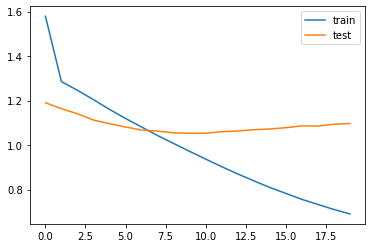

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference
- Getting encoder states
- 

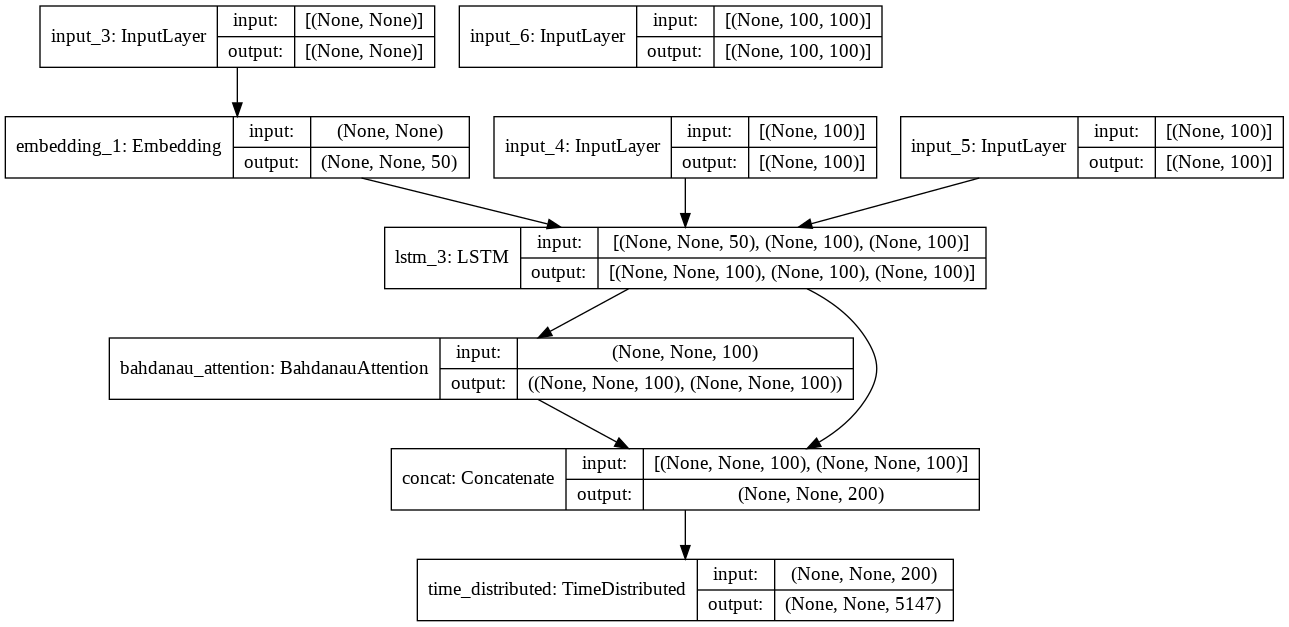

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, h_final, c_final])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_input_state_h = Input(shape=(time_dim,))
decoder_input_state_c = Input(shape=(time_dim,))
decoder_input_hidden_state = Input(shape=(max_text_len,time_dim))

# Get the embeddings of the decoder sequence
dec_emb_inference= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb_inference, initial_state=[decoder_input_state_h, decoder_input_state_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer( decoder_outputs2,decoder_input_hidden_state)
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_input_hidden_state,decoder_input_state_h, decoder_input_state_c],
    [decoder_outputs2] + [state_h2, state_c2])
import keras
keras.utils.all_utils.plot_model(decoder_model, "Inference.png", show_shapes=True)

We are defining a function below which is the implementation of the inference process:

In [ ]:
def decode_sequence(text_seq):

    encoder_out, encoder_h, encoder_c = encoder_model.predict(text_seq)
    
    summary_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the startsymbol word.
    summary_seq[0, 0] = target_word_index['startsymbol']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([summary_seq] + [encoder_out, encoder_h, encoder_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endsymbol'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endsymbol'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        summary_seq = np.zeros((1,1))
        summary_seq[0, 0] = sampled_token_index

        # Update internal states
        encoder_h, encoder_c = h, c

    return decoded_sentence

Here are a few summaries generated by the model on our validation dataset:

In [ ]:
def vec_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['startsymbol']) and i!=target_word_index['endsymbol']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def vec_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

for i in range(0,50):
    print("Long Text Sentence:",vec_to_text(x_val[i]))
    print("Reference Summary:",vec_to_summary(y_val[i]))
    print("Predicted Summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")



Long Text Sentence: bought this along with the regular dark roast at considerable discounted price well lets just say you get what you pay for the flavor really is not there and this as well is not much of dark roast 
Reference Summary: okay 
Predicted Summary:  great


Long Text Sentence: leibniz cookies are truly my favorite beyond what make am cook the whole wheat version of these are particularly superb with subtly greater flavor than the original and lovely slightly more crumbly and grainy texture it has been wonderful discovery bon appetit 
Reference Summary: de licious with perfect packaging 
Predicted Summary:  great tasting cookie


Long Text Sentence: received keurig brewer for christmas and also received pack of this hot chocolate with it we made some after sledding one day for myself my husband and kids all thought it was terrible we almost returned the keurig brewer because of it have found that am enjoying black coffee with my keurig but we will never buy any type of hot 

In [ ]:
ref_summ= [vec_to_summary(s) for s in y_val ]
pred_summ= [decode_sequence(s.reshape(1,max_text_len)) for s in x_val ]

result = pd.DataFrame({'ref':ref_summ,'pred':pred_summ})
result.replace("", float("NaN"), inplace=True)
result.replace(" ", float("NaN"), inplace=True)

#dropping duplicates
#dropping na
result.dropna(axis=0,inplace=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 1527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ref     1499 non-null   object
 1   pred    1499 non-null   object
dtypes: object(2)
memory usage: 35.1+ KB


In [ ]:
!pip install rouge
from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(result['pred'], result['ref'], avg=True)


scores